# Setup

## Modules and functions

In [2]:
from statsmodels.formula.api import ols
import numpy as np
import pandas as pd
import HTfunctions as ht
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
import descartes
from shapely.geometry import Point,Polygon
import math
from matplotlib import gridspec
import itertools
import seaborn as sns

## Importing data

In [3]:
file = ht.findFiles("*Mag*snowmelt_*ost*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles("*Mag*rainfall_*ost*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles("*Mag*stream*ost*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles("*Mag*temp*ost*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_PROstreamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy


In [4]:
# checking that trend arrays are all same shape
print(snowmelt.shape)
print(rainfall.shape)
print(streamflow.shape)
print(temperature.shape)

(51, 365)
(51, 365)
(51, 365)
(51, 365)


In [5]:
# getting the snumbers of the catchments
final = ht.openDict("Data/finalSelectionList.pkl")
catchments = final["ost"]["1983-2012"]
# checking that the list is correct length
len(catchments)

51

In [6]:
meta = pd.read_csv("Data/newFinalSelection_1983_2012.csv",index_col=0)

## Quality functions

In [7]:
def rmse(mod,obs):
    out = np.sqrt(((mod-obs)**2).mean())
    return out

def nse(mod,obs):
    out = 1 - (((mod-obs)**2).sum()/((obs-obs.mean())**2).sum())
    return out

## Splitting by season

In [8]:
# first day of spring
springday = 60

# first day of summer
summerday = 152

# first day of autumn, 01.09 (also first day of norwegian hydrological year)
autumnday = 244

# first day of winter
winterday = 335

Text(0, 0.5, 'Snowmelt/rainfall/temperature trend')

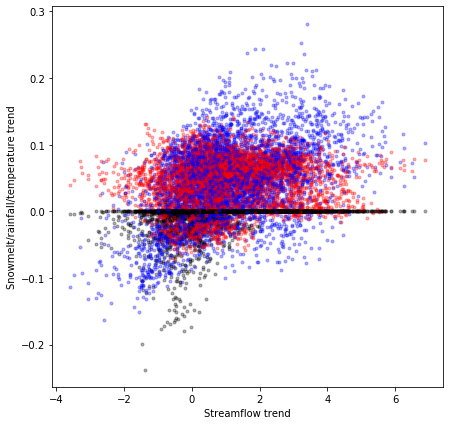

In [9]:
start = summerday
end = autumnday

kwargs = {"alpha":0.3,
          "marker":".",
          "linestyle":""}

plt.figure(figsize=(7,7))
for c in range(streamflow.shape[0]):
    plt.plot(streamflow[c,start:end],snowmelt[c,start:end],color="k",**kwargs)
    plt.plot(streamflow[c,start:end],rainfall[c,start:end],color="b",**kwargs)
    plt.plot(streamflow[c,start:end],temperature[c,start:end],color="r",**kwargs)
    
plt.xlabel("Streamflow trend")
plt.ylabel("Snowmelt/rainfall/temperature trend")

In [10]:
def splitBySeason(array,season,firstDayOfSeasons = (60,152,244,335)):
    """
    Slices 2D array with shape (catchments,doy) or a 1D with shape (doy,) by a specified season.
    
    Parameters
    ----------
    array: np.array
        shape: (catchments,doy)
    season: str
        "spring","sp"
        "summer","su"
        "autumn","fall","au"
        "winter","wi"
    firstDayOfSeasons: tuple (springday,summerday,autumnday,winterday)
        springday: first day of spring, default 01.03.
        summerday: first day of summer, default 01.06.
        autumnday: first day of autumn, default 01.09. (also first day of norwegian hydrological year)
        winterday: first day of winter, default 01.12.
    
    Returns
    -------
    arr: np.array
        array sliced by season
    """
    
    springday,summerday,autumnday,winterday = firstDayOfSeasons
    
    # 2D arrays
    if len(array.shape)==2:
        if (season=="spring" or season=="sp"):
            start = springday
            end = summerday
            arr = array[:,start:end]
        elif (season=="summer" or season=="su"):
            start = summerday
            end = autumnday
            arr = array[:,start:end]
        elif (season=="autumn" or season=="fall" or season=="au"):
            start = autumnday
            end = winterday
            arr = array[:,start:end]
        elif (season=="winter" or season=="wi"):
            a = array[:,winterday:]
            b = array[:,:springday]
            arr = np.hstack([a,b])
        else:
            print("Please input correct season identifier.")
    
    # 1D arrays
    elif len(array.shape)==1:
        if (season=="spring" or season=="sp"):
            start = springday
            end = summerday
            arr = array[start:end]
        elif (season=="summer" or season=="su"):
            start = summerday
            end = autumnday
            arr = array[start:end]
        elif (season=="autumn" or season=="fall" or season=="au"):
            start = autumnday
            end = winterday
            arr = array[start:end]
        elif (season=="winter" or season=="wi"):
            a = array[winterday:]
            b = array[:springday]
            arr = np.hstack([a,b])
        else:
            print("Please input correct season identifier.")
    
    # error if array is more than 2D
    else:
        print("Array must be 1D or 2D.")
    
    return arr

# Multiple regression (streamflow, snowmelt, rainfall trends)

## Functions

Calculating the correlation between streamflow trend and snowmelt and rainfall trend for all catchments (separately). 

In [16]:
def OLSregionArray(streamflow,snowmelt,rainfall,catchments,addTemp=False,temperature=None,withoutSnow=False):
    """
    OLS regression on daily streamflow, snowmelt and rainfall trends.
    Streamflow as dependent variable y, snowmelt and rainfall as indepenent variables x1,x2:
    y ~ x1 + x2
    
    Parameters
    ----------
    streamflow: numpy.array
    snowmelt: numpy.array
    rainfall:numpy.array
    catchments: list
    lag: int
        default: 0
        as the streamflow trends often lag behind the other two,
        the lag parameter will shift the streamflow timeseries relative to the others
    
    Returns
    -------
    results: dictionary 
        with results from all catchments, with snumber of catchments as keys
        each results[snumber] is a dictionary containing:
            "summary": str
                a model summary that can be printed
            "observed_qtrend": numpy.array
                the observed streamflow trend in that catchment
            "modelled_qtrend": numpy.array
                the streamflow trend predicted by the model
            "model": statsmodels.regression.linear_model.RegressionResultsWrapper
                the linear regression model
    """
    
    results = {}

    for c in range(streamflow.shape[0]):
        # getting the snumber of catchment
        snumber = catchments[c]

        # creating an empty dictionary with snumber as key
        results[snumber] = {}

        # modelling
        # adjusting for lag between snowmelt/rainfall and streamflow trends
        snow = snowmelt[c,:]
        rain = rainfall[c,:]
        stream = streamflow[c,:]
        results[snumber]["observed_qtrend"] = stream
        if addTemp:
            temp = temperature[c,:]

        # linear model with two independent variables
        data = pd.DataFrame({'x1': snow, 'x2': rain, 'y': stream})
        model = ols("y ~ x1 + x2", data).fit()
        results[snumber]["model"] = model
        # with three independent variables
        if addTemp:
            data = pd.DataFrame({'x1': snow, 
                                 'x2': rain,
                                 'x3':temp,
                                 'y': stream})
            model = ols("y ~ x1 + x2 + x3", data).fit()
            results[snumber]["model"] = model
        
        if withoutSnow:
            data = pd.DataFrame({'x1': rain, 
                                 'x2': temp,
                                 'y': stream})
            model = ols("y ~ x1 + x2", data).fit()
            results[snumber]["model"] = model

        # model summary as string
        results[snumber]["summary"] = str(model.summary())

        # predictions of the model
        results[snumber]["modelled_qtrend"] = model.predict()
        
        results[snumber]["corr"] = data.corr()
    
    return results

def OLSresultsToDataFrame(results,temp=False):
    d = {}
    for c in catchments:
        d[c] = {}
        d[c]["rsquared_adj"] = results[c]["model"].rsquared_adj
        d[c]["aic"] = results[c]["model"].aic
        #d[c]["rmse"] = rmse(mod,obs)
        d[c]["intercept"] = results[c]["model"].params.Intercept
        d[c]["x1_snow"] = results[c]["model"].params.x1
        d[c]["x2_rain"] = results[c]["model"].params.x2
        if temp:
            d[c]["x3_temp"] = results[c]["model"].params.x3
    df = pd.DataFrame.from_dict(d,orient="index")
    df.index.name = "snumber"
    return df

def plotOLSresults(results,catchments,region,period,temp=False):
    for c in catchments:
        obs = results[c]["observed_qtrend"]
        mod = results[c]["modelled_qtrend"]
        params = results[c]['model'].params
        
        fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
        ax[1].plot(obs,mod,"xk")
        ax[1].set_xlabel("Observed streamflow trend")
        ax[1].set_ylabel("Predicted streamflow trend")
        ax[1].set_title(f"$R^2(adj) =$  {results[c]['model'].rsquared_adj:.3}" ,loc="left")

        ax[0].plot(obs,label="Observed streamflow trend")
        ax[0].plot(mod,label="Predicted streamflow trend")
        ax[0].legend()
        ax[0].set_xlabel("Day of year")
        ax[0].set_ylabel("Streamflow trend $m^3 s^{-1} \ yr^{-1}$")
        
        if temp:
            ax[0].set_title(f"Qtrend = {params.Intercept:.2} + {params.x1:.2} SMtrend + {params.x2:.2} RFtrend + {params.x3:.2} Ttrend",
                            loc="left")
        else:
            ax[0].set_title(f"Qtrend = {params.Intercept:.2} + {params.x1:.2} SMtrend + {params.x2:.2} RFtrend",
                            loc="left")

        if temp:
            plt.savefig(f"Plots/1983_2012/OLS/OLS_3predictors_{c}_{region}_{period}.png",dpi=400)
        else:
            plt.savefig(f"Plots/1983_2012/OLS/OLS_{c}_{region}_{period}.png",dpi=400)
        plt.close()

### Testing for a season

In [11]:
season = "spring"
test = OLSregionArray(splitBySeason(streamflow,season),
                      splitBySeason(snowmelt,season),
                      splitBySeason(rainfall,season),
                      catchments,
                      addTemp=True,
                      temperature = splitBySeason(temperature,season))

In [12]:
test.keys()

dict_keys([200291, 200268, 200013, 200290, 1200013, 200284, 200025, 1200197, 1200137, 1500079, 200032, 200614, 200145, 200129, 1200097, 1500049, 1200099, 1500053, 1600066, 1200207, 200011, 1200070, 200607, 1600122, 1600075, 1200171, 1200200, 1600010, 200028, 1200178, 31100460, 1600051, 200604, 200267, 31100004, 31100006, 1200113, 1200188, 200323, 1500021, 200280, 1600194, 200279, 200142, 200616, 800002, 600010, 1200193, 800006, 200633, 300022])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     190.9
Date:                Tue, 14 Jan 2020   Prob (F-statistic):           2.12e-38
Time:                        16:07:35   Log-Likelihood:                -19.638
No. Observations:                  92   AIC:                             47.28
Df Residuals:                      88   BIC:                             57.36
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0708      0.125     -0.565      0.5

Text(0, 0.5, 'Streamflow trend $m^3 s^{-1} \\ yr^{-1}$')

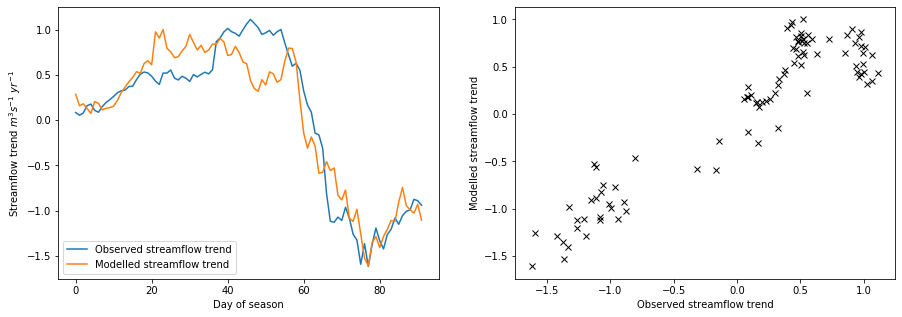

In [13]:
c = catchments[16]

print(test[c]["summary"])

obs = test[c]["observed_qtrend"]
mod = test[c]["modelled_qtrend"]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax[1].plot(obs,mod,"xk")
ax[1].set_xlabel("Observed streamflow trend")
ax[1].set_ylabel("Modelled streamflow trend")

ax[0].plot(obs,label="Observed streamflow trend")
ax[0].plot(mod,label="Modelled streamflow trend")
ax[0].legend()
ax[0].set_xlabel("Day of season")
ax[0].set_ylabel("Streamflow trend $m^3 s^{-1} \ yr^{-1}$")


In [14]:
test[c]["corr"]

,x1,x2,x3,y
x1,1.000000,-0.384276,0.928427,0.922863
x2,-0.384276,1.000000,-0.289477,-0.274981
x3,0.928427,-0.289477,1.000000,0.895014
y,0.922863,-0.274981,0.895014,1.000000


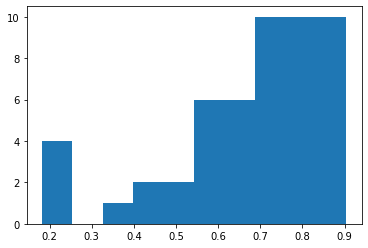

In [15]:
df = OLSresultsToDataFrame(test)
df.rsquared_adj.hist(grid=False)

## Running for all seasons

### Q ~ SM + RF + T

In [17]:
for region in ["ost","vest","nord","sor","trond","finn"]:
    catchments = final[region]["1983-2012"]
    
    file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
    print(file)
    snowmelt = np.load(file)

    file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
    print(file)
    rainfall = np.load(file)

    file = ht.findFiles(f"*Mag*_stream*{region}*1983*","Results/Daily")[0]
    print(file)
    streamflow = np.load(file)

    file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
    print(file)
    temperature = np.load(file)

    for season in ["autumn","spring","summer","winter"]:
        results = OLSregionArray(splitBySeason(streamflow,season),
                                 splitBySeason(snowmelt,season),
                                 splitBySeason(rainfall,season),
                                 catchments,
                                 addTemp=True,
                                 temperature = splitBySeason(temperature,season))
        ht.saveDict(results,f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012_{season}")
        df = OLSresultsToDataFrame(results)
        df.to_csv(f"Results/OLS/multiregression_QSMRFT_{region}_1983_2012_{season}.csv")

Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_

### Q ~ SM + RF

In [15]:
for region in ["ost","vest","nord","sor","trond","finn"]:
    catchments = final[region]["1983-2012"]
    
    file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
    print(file)
    snowmelt = np.load(file)

    file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
    print(file)
    rainfall = np.load(file)

    file = ht.findFiles(f"*Mag*_stream*{region}*1983*","Results/Daily")[0]
    print(file)
    streamflow = np.load(file)

    file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
    print(file)
    temperature = np.load(file)

    for season in ["autumn","spring","summer","winter"]:
        results = OLSregionArray(splitBySeason(streamflow,season),
                                 splitBySeason(snowmelt,season),
                                 splitBySeason(rainfall,season),
                                 catchments,
                                 addTemp=False,
                                 temperature = splitBySeason(temperature,season))
        ht.saveDict(results,f"Results/OLS/multiregression_QSMRF_{region}_1983_2012_{season}")
        df = OLSresultsToDataFrame(results)
        df.to_csv(f"Results/OLS/multiregression_QSMRF_{region}_1983_2012_{season}.csv")

Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy


/home/skalevag/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
/home/skalevag/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model


Results/Daily/trendMagnitudes_snowmelt_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_trond_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_trond_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_trond_10dMA_1983_2012.npy
Results/Daily/trendMagni

### Q ~ RF + T

In [32]:
for region in ["ost","vest","nord","sor","trond","finn"]:
    catchments = final[region]["1983-2012"]
    
    file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
    print(file)
    snowmelt = np.load(file)

    file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
    print(file)
    rainfall = np.load(file)

    file = ht.findFiles(f"*Mag*_stream*{region}*1983*","Results/Daily")[0]
    print(file)
    streamflow = np.load(file)

    file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
    print(file)
    temperature = np.load(file)

    for season in ["autumn","spring","summer","winter"]:
        results = OLSregionArray(splitBySeason(streamflow,season),
                                 splitBySeason(snowmelt,season),
                                 splitBySeason(rainfall,season),
                                 catchments,
                                 addTemp=True,
                                 temperature = splitBySeason(temperature,season),
                                 withoutSnow=True)
        ht.saveDict(results,f"Results/OLS/multiregression_QRFT_{region}_1983_2012_{season}")
        df = OLSresultsToDataFrame(results)
        df.to_csv(f"Results/OLS/multiregression_QRFT_{region}_1983_2012_{season}.csv")

Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_vest_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_nord_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_snowmelt_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_streamflow_sor_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_

### Q ~ SM

In [ ]:
formula = "Qpro ~ RFpro + SMpro + T + GM + Qgradpro + grad"

df = dfs[region]["all"]
model = ols(formula, df).fit()


# Results

## Correlation between variables

### Single season

In [19]:
def plotVarCorrelation(results,ncols=5):
    N = len(results.keys())
    cols = ncols
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(cols*2,rows*2))

    cmap = plt.cm.get_cmap("coolwarm")
    cmap.set_bad(color="white")

    for n in range(N):
        c = list(results.keys())[n]
        corr = results[c]["corr"]
        for lab in corr.columns:
            corr.loc[lab,lab]=np.nan
        ax = fig.add_subplot(gs[n])
        im = ax.matshow(corr,cmap=cmap,vmin=-1,vmax=1)
        ax.xaxis.set_ticks_position('bottom')
        ax.set_yticklabels(["","SM","RF","T","Q"])
        ax.set_xticklabels(["","SM","RF","T","Q"])
        ax.set_title(c)
        
        # adding labels
        kwargs = {"ha":"center","va":"center","fontsize":9}
        ax.text(0,1,f"{corr.iloc[0,1]:.2f}",**kwargs)
        ax.text(0,2,f"{corr.iloc[0,2]:.2f}",**kwargs)
        ax.text(0,3,f"{corr.iloc[0,3]:.2f}",**kwargs)
        ax.text(1,2,f"{corr.iloc[1,2]:.2f}",**kwargs)
        ax.text(1,3,f"{corr.iloc[1,3]:.2f}",**kwargs)
        ax.text(2,3,f"{corr.iloc[2,3]:.2f}",**kwargs)
    #fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.02, 0.5, 0.03, 0.15])
    fig.colorbar(im, cax=cbar_ax,label="Pearson correlation coefficient")
    fig.tight_layout()

In [20]:
test = ht.openDict("Results/OLS/multiregression_QSMRFT_ost_1983_2012_spring.pkl")

/home/skalevag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


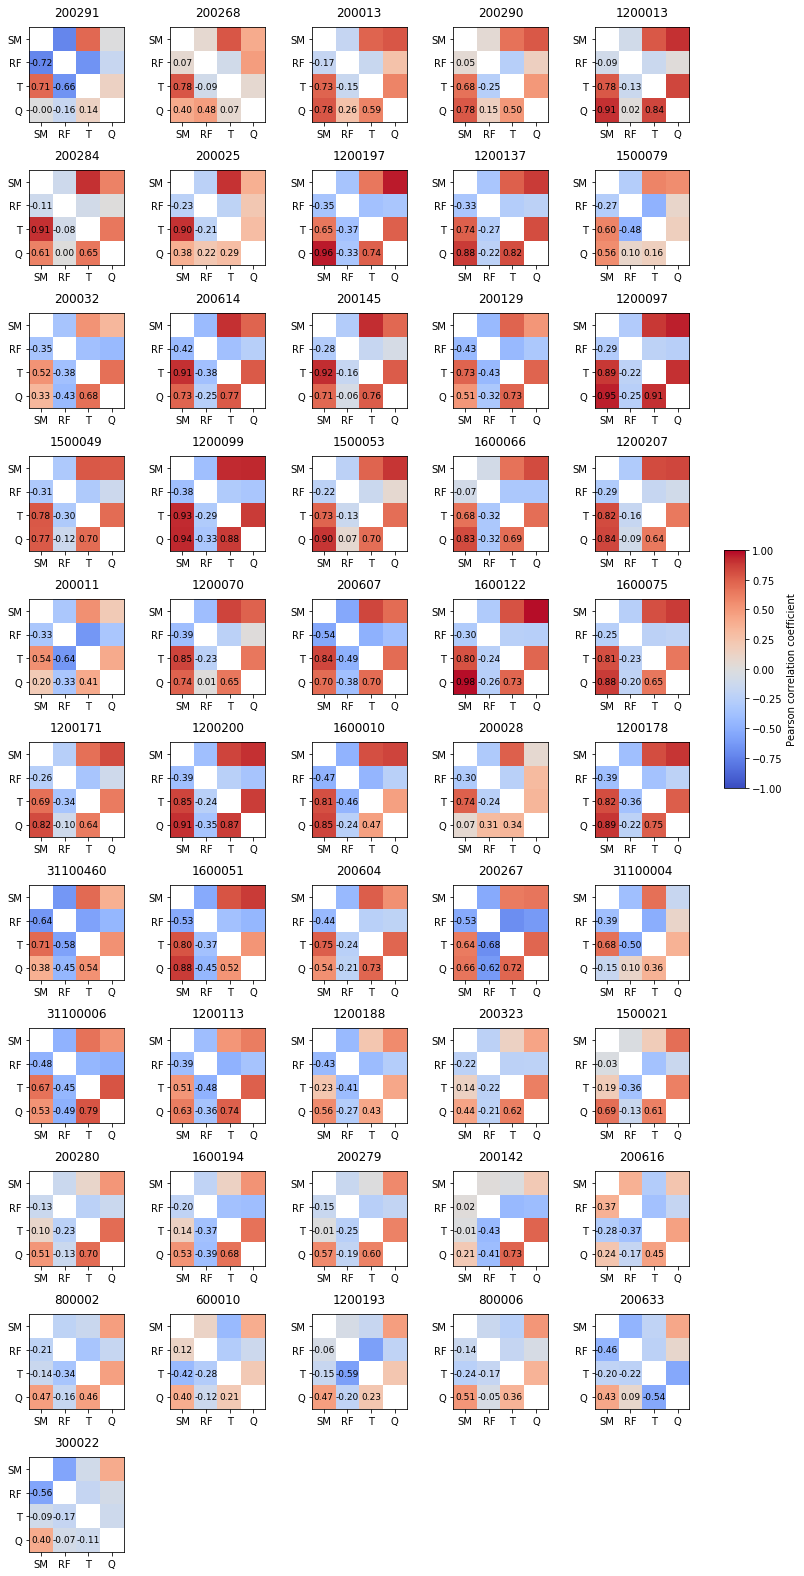

In [21]:
plotVarCorrelation(test)

### All seasons and annually compared

In [22]:
def plotVarCorrelationTotal(results):
    """
    Plots correlation between variables for annual and seasonal.
    """
    # results = (ann,spring,summer,autumn,winter)
    
    cmap = plt.cm.get_cmap("coolwarm")
    cmap.set_bad(color="white")
    
    cols = len(results)
    rows = len(ann.keys())
    fig,ax = plt.subplots(figsize=(cols*2,rows*2),nrows=rows,ncols=cols)
    
    titles = ["Annual","Spring","Summer","Autumn","Winter"]
    for col in range(cols):
        res = results[col]
        for row in range(rows):
            c = list(res.keys())[row]
            corr = res[c]["corr"]
            for lab in corr.columns:
                corr.loc[lab,lab]=np.nan
            im = ax[row,col].matshow(corr,cmap=cmap,vmin=-1,vmax=1)
            ax[row,col].xaxis.set_ticks_position('bottom')
            ax[row,col].set_yticklabels(["","SM","RF","T","Q"])
            ax[row,col].set_xticklabels(["","SM","RF","T","Q"])
            if row==0:
                ax[row,col].set_title(titles[col])
            if col==0:
                ax[row,col].set_ylabel(c)
            # adding labels
            kwargs = {"ha":"center","va":"center","fontsize":9}
            ax[row,col].text(0,1,f"{corr.iloc[0,1]:.2f}",**kwargs)
            ax[row,col].text(0,2,f"{corr.iloc[0,2]:.2f}",**kwargs)
            ax[row,col].text(0,3,f"{corr.iloc[0,3]:.2f}",**kwargs)
            ax[row,col].text(1,2,f"{corr.iloc[1,2]:.2f}",**kwargs)
            ax[row,col].text(1,3,f"{corr.iloc[1,3]:.2f}",**kwargs)
            ax[row,col].text(2,3,f"{corr.iloc[2,3]:.2f}",**kwargs)
    #fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.02, 0.5, 0.03, 0.15])
    fig.colorbar(im, cax=cbar_ax,label="Pearson correlation coefficient")
    fig.tight_layout()

In [23]:
for region in ["ost","vest"]:
    files = ht.findFiles(f"*QSMRFT*{region}*.pkl","Results/OLS")
    for file in files:
        print(file)
    ann = ht.openDict(files[0])
    autumn = ht.openDict(files[1])
    spring = ht.openDict(files[2])
    summer = ht.openDict(files[3])
    winter = ht.openDict(files[4])
    results = (ann,spring,summer,autumn,winter)
    plotVarCorrelationTotal(results)
    #plt.savefig(f"Plots/1983_2012/variableCorrelation_{region}_1983_2012.png",dpi=300,bbox_inches='tight')
    plt.close()

Results/OLS/multiregression_QSMRFT_ost_1983_2012.pkl
Results/OLS/multiregression_QSMRFT_ost_1983_2012_autumn.pkl
Results/OLS/multiregression_QSMRFT_ost_1983_2012_spring.pkl
Results/OLS/multiregression_QSMRFT_ost_1983_2012_summer.pkl
Results/OLS/multiregression_QSMRFT_ost_1983_2012_winter.pkl


/home/skalevag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Results/OLS/multiregression_QSMRFT_vest_1983_2012.pkl
Results/OLS/multiregression_QSMRFT_vest_1983_2012_autumn.pkl
Results/OLS/multiregression_QSMRFT_vest_1983_2012_spring.pkl
Results/OLS/multiregression_QSMRFT_vest_1983_2012_summer.pkl
Results/OLS/multiregression_QSMRFT_vest_1983_2012_winter.pkl


## Multiple regression

### R² histograms

In [24]:
region = "ost"

dfs = []
for file in ht.findFiles(f"*QSMRFT*{region}*.csv","Results/OLS"):
    print(file)
    dfs.append(pd.read_csv(file))
ann,autumn,spring,summer,winter = tuple(dfs)

Results/OLS/multiregression_QSMRFT_ost_1983_2012.csv
Results/OLS/multiregression_QSMRFT_ost_1983_2012_autumn.csv
Results/OLS/multiregression_QSMRFT_ost_1983_2012_spring.csv
Results/OLS/multiregression_QSMRFT_ost_1983_2012_summer.csv
Results/OLS/multiregression_QSMRFT_ost_1983_2012_winter.csv


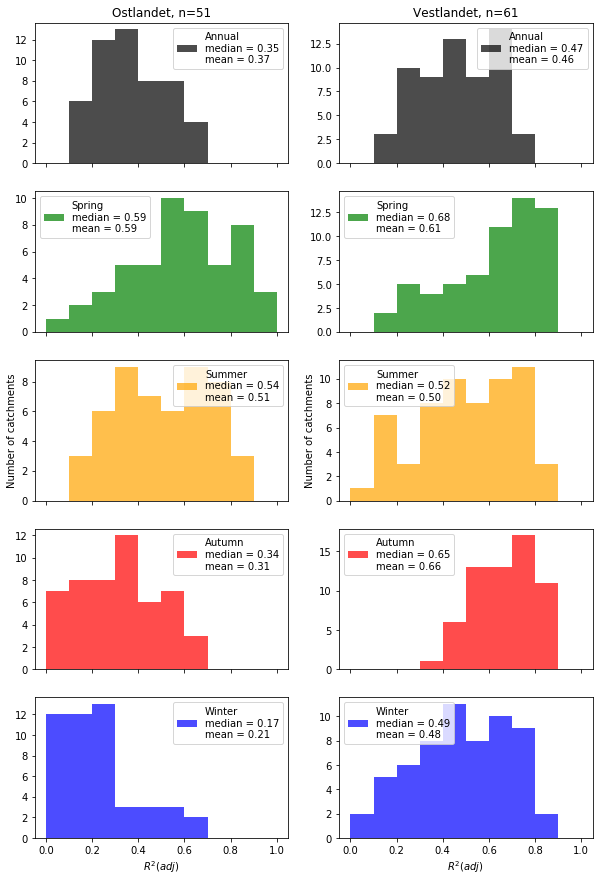

In [25]:
kwargs = {"grid":False,
          "range":(0,1),
          "bins":10,
          "alpha":0.7,
          "linewidth":3}

color = itertools.cycle(("k","g","orange","r","b"))
sLabels = ["Annual","Spring","Summer","Autumn","Winter"]
regions = ["ost","vest"]
title = ["Ostlandet, n=51","Vestlandet, n=61"]

fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(10,15),sharex=True)
for i in range(2):
    region = regions[i]
    dfs = []
    for file in ht.findFiles(f"*QSMRFT*{region}*.csv","Results/OLS"):
        dfs.append(pd.read_csv(file))
    ann,autumn,spring,summer,winter = tuple(dfs)
    
    df_seasons = [ann,spring,summer,autumn,winter]
    for s in range(5):
        df = df_seasons[s]
        df.rsquared_adj.hist(ax=ax[s,i],
                    **kwargs,
                    label=f"{sLabels[s]}\nmedian = {df.rsquared_adj.median():.2}\nmean = {df.rsquared_adj.mean():.2f}",
                    fc = next(color))
    
    ax[0,i].set_title(title[i])
    ax[2,i].set_ylabel("Number of catchments")
    ax[4,i].set_xlabel("$R^2(adj)$")
    ax[0,i].legend()
    ax[1,i].legend()
    ax[2,i].legend()
    ax[3,i].legend()
    ax[4,i].legend()
    
plt.savefig("Plots/1983_2012/OLS/histogram_multiregression_bySeason_1983_2012.png",dpi=300,bbox_inches="tight")

### Maps

#### Function

In [26]:
def multiRegressMaps(season,version):
    file = ht.findFiles(f"*{version}_*ost*{season}*.csv","Results/OLS")[0]
    print(file)
    ost = pd.read_csv(file)
    file = ht.findFiles(f"*{version}_*vest*{season}*.csv","Results/OLS")[0]
    print(file)
    vest = pd.read_csv(file)
    ht.plotRegressionQualityLocation(vest,ost)
    plt.title(season.upper())
    plt.savefig(f"Plots/1983_2012/OLS/map_multiregression_{version}_{season}_1983_2012.png",dpi=300,bbox_inches="tight")

#### Maps

Results/OLS/multiregression_QSMRF_ost_1983_2012_autumn.csv
Results/OLS/multiregression_QSMRF_vest_1983_2012_autumn.csv


/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Results/OLS/multiregression_QSMRF_ost_1983_2012_spring.csv
Results/OLS/multiregression_QSMRF_vest_1983_2012_spring.csv
Results/OLS/multiregression_QSMRF_ost_1983_2012_summer.csv
Results/OLS/multiregression_QSMRF_vest_1983_2012_summer.csv


/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Results/OLS/multiregression_QSMRF_ost_1983_2012_winter.csv
Results/OLS/multiregression_QSMRF_vest_1983_2012_winter.csv


/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


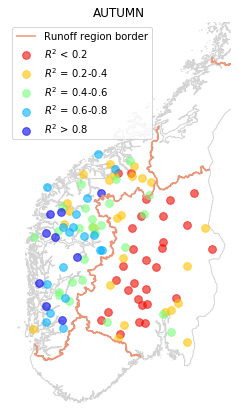

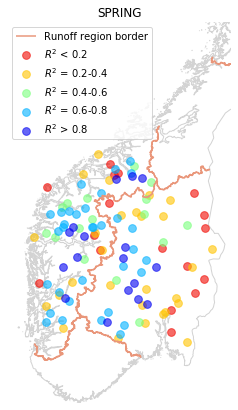

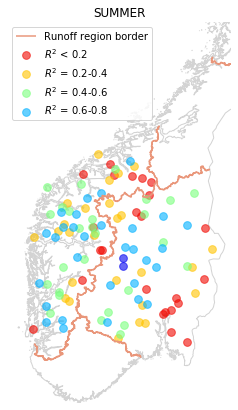

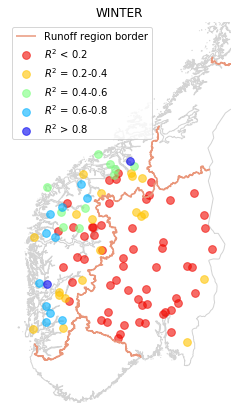

In [27]:
version = "QSMRF"
for season in ["autumn","spring","summer","winter"]:
    multiRegressMaps(season,version)

Results/OLS/multiregression_QSMRFT_ost_1983_2012_autumn.csv
Results/OLS/multiregression_QSMRFT_vest_1983_2012_autumn.csv


/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Results/OLS/multiregression_QSMRFT_ost_1983_2012_spring.csv
Results/OLS/multiregression_QSMRFT_vest_1983_2012_spring.csv
Results/OLS/multiregression_QSMRFT_ost_1983_2012_summer.csv
Results/OLS/multiregression_QSMRFT_vest_1983_2012_summer.csv
Results/OLS/multiregression_QSMRFT_ost_1983_2012_winter.csv
Results/OLS/multiregression_QSMRFT_vest_1983_2012_winter.csv


/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


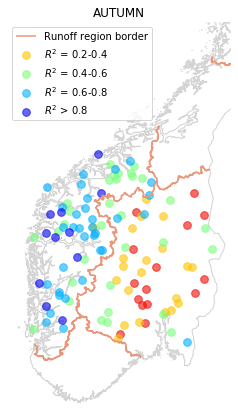

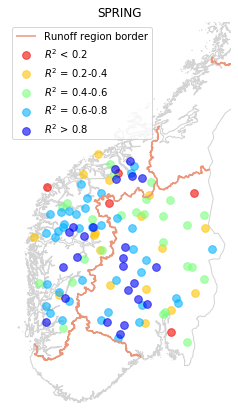

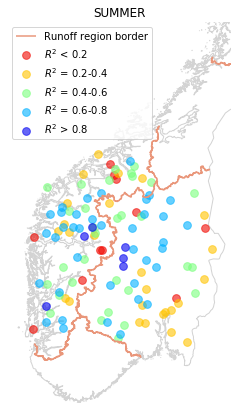

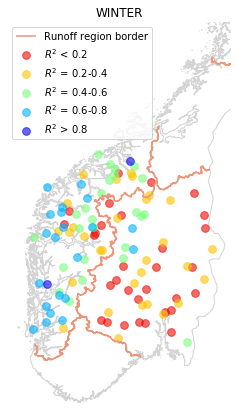

In [28]:
version = "QSMRFT"
for season in ["autumn","spring","summer","winter"]:
    multiRegressMaps(season,version)

Results/OLS/multiregression_QRFT_ost_1983_2012_autumn.csv
Results/OLS/multiregression_QRFT_vest_1983_2012_autumn.csv


/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Results/OLS/multiregression_QRFT_ost_1983_2012_spring.csv
Results/OLS/multiregression_QRFT_vest_1983_2012_spring.csv
Results/OLS/multiregression_QRFT_ost_1983_2012_summer.csv
Results/OLS/multiregression_QRFT_vest_1983_2012_summer.csv


/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Results/OLS/multiregression_QRFT_ost_1983_2012_winter.csv
Results/OLS/multiregression_QRFT_vest_1983_2012_winter.csv


/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


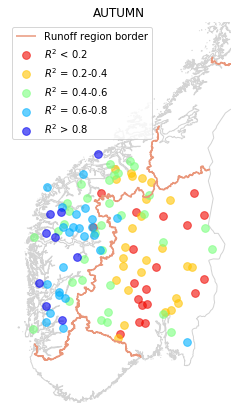

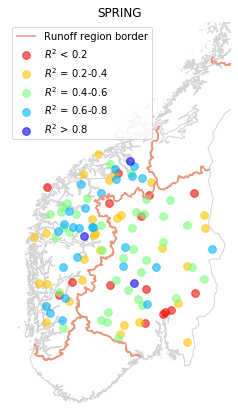

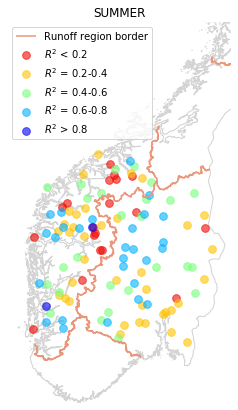

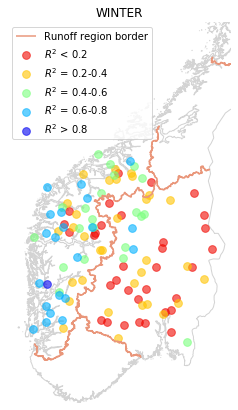

In [29]:
version = "QRFT"
for season in ["autumn","spring","summer","winter"]:
    multiRegressMaps(season,version)

# Season sums

Summing the trends in each season should be roughly equivalent to the seasonal trend.

In [10]:
region = "ost"

file = ht.findFiles(f"*Mag*snowmelt_*{region}*1983*","Results/Daily")[0]
print(file)
snowmelt = np.load(file)

file = ht.findFiles(f"*Mag*rainfall_*{region}*1983*","Results/Daily")[0]
print(file)
rainfall = np.load(file)

file = ht.findFiles(f"*Mag*stream*{region}*1983*","Results/Daily")[0]
print(file)
streamflow = np.load(file)

file = ht.findFiles(f"*Mag*temp*{region}*1983*","Results/Daily")[0]
print(file)
temperature = np.load(file)

Results/Daily/trendMagnitudes_snowmelt_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_rainfall_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_PROstreamflow_ost_10dMA_1983_2012.npy
Results/Daily/trendMagnitudes_temperature_ost_10dMA_1983_2012.npy


In [19]:
def sumBySeason(array,season):
    a = splitBySeason(array,season)
    b = np.nansum(a,axis=1)
    return b

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Q   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     19.00
Date:                Wed, 15 Jan 2020   Prob (F-statistic):           8.33e-07
Time:                        16:00:50   Log-Likelihood:                -274.82
No. Observations:                  51   AIC:                             555.6
Df Residuals:                      48   BIC:                             561.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1172     27.510      0.150      0.882     -51.196      59.431
SM            39.3954      7.556      5.214      0.000      24.203      54.588
RF            27.6079      6.428      4.295      0.000      14.684      40.532
==============================================================================
Omnibus:                        0.662   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.781
Skew:                          -0.213   Prob(JB):                        0.677
Kurtosis:                       2.569   Cond. No.                         16.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

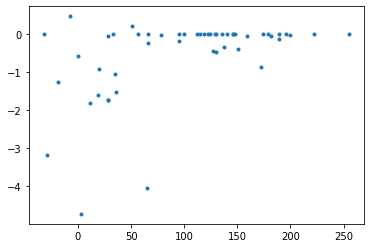

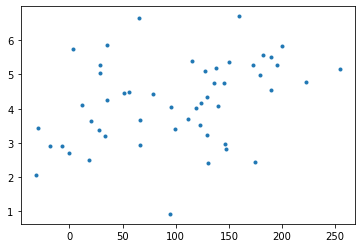

In [39]:
season = "summer"
Q = sumBySeason(streamflow,season)
SM = sumBySeason(snowmelt,season)
RF = sumBySeason(rainfall,season)

plt.plot(Q,SM,".")
plt.figure()
plt.plot(Q,RF,".")

df = pd.DataFrame({"Q":Q,"SM":SM,"RF":RF})

model = ols("Q ~ SM + RF", df).fit()
model.summary()

In [34]:
365/5

73.0